## Ejercicio 2 
### Forecast de precios

* El director general te ha pedido que elabores un modelo de predicción de precios del gas natural, para lo cual debes de utilizar los precios históricos que se te enviaron (elige cualquiera de las dos series históricas: Waha o Houston).
* Sospechamos que Las principales variables que influyen en el precio son: el Clima en estados Unidos, la expectativa de demanda tanto de Estados Unidos como de otras regiones como Europa (variables que están correlacionadas con el clima futuro). Pero puede haber otras variables significativas.
* El objetivo es elaborar un modelo de machine learning para predecir los precios en el corto plazo (días) (ver paper anexo de Xu & Baldick 2019).


Al pensar en hacer un ejerecicio de pronostico, se me ocurriria usar un modelo ARIMA o una LSTM para calcular los precios.
El ejercicio sera intentar hacer ambos y comparar los pronosticos.
* Para el modelo ARIMA no es necesario mas que la misma serie de tiempo.
* En el caso de la red neuronal (LSTM) es aconsejable crear una base de datos robusta.

In [1]:
# Imporamos las librerias que utilizaremos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import datetime as dt
import warnings 
#Importing the libraries
from nsepy import get_history as gh
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pmdarima import auto_arima 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

In [28]:
# Para que el archivo sea reproducible
random.seed(17072021)
# Ignore harmless warnings 
warnings.filterwarnings("ignore") 

In [3]:
# Importamos nuestros datos
df = pd.read_csv('data/cfe/data_historicos.csv')
df.rename(columns={'Fecha': 'date', 'Houston ShipChl (USD/MMB)': 'shipchi', 'Waha (USD/MMB)':'waha'}, inplace = True)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

Parece haber un cambio abrupto en el ultimo año por lo que veremos con mayor detalle esos datos.

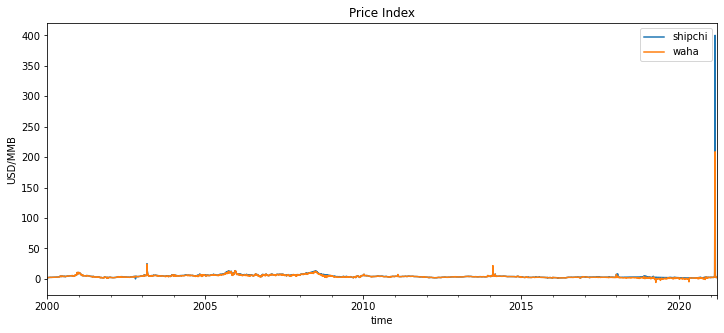

In [4]:
# Observamos nuestros datos
df.plot(x = 'date',figsize=(12, 5))
plt.title("Price Index")
plt.xlabel("time")
plt.ylabel("USD/MMB")
plt.show()

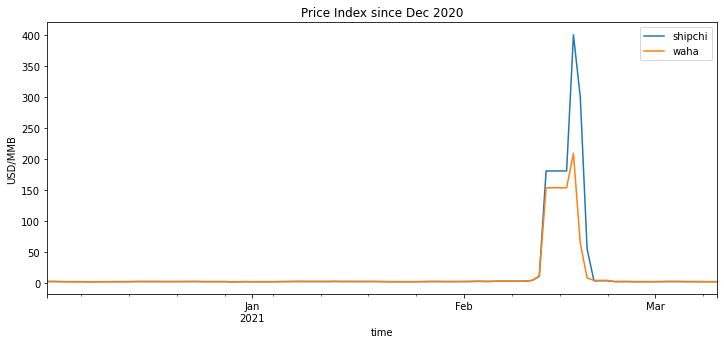

In [5]:
df[(df['date'] > '2020-12-01')].plot(x = 'date',figsize=(12, 5))
plt.title("Price Index since Dec 2020")
plt.xlabel("time")
plt.ylabel("USD/MMB")
plt.show()

Parece ser que podrian haber unos posibles outliers en el mes de febrero de 2021, pero estos datos pueden ser posiblemente ocacionados por los apagones de Texas en febrero de 2021

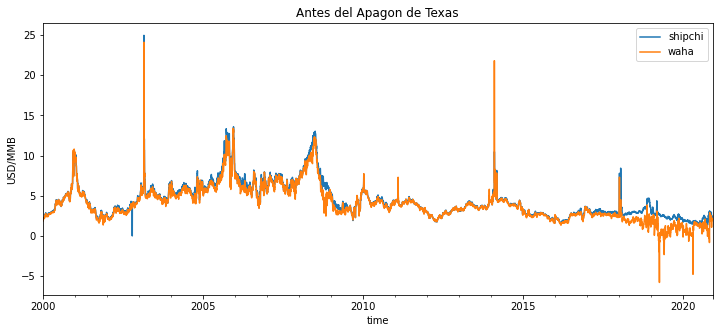

In [6]:
df[(df['date'] < '2020-12-01')].plot(x = 'date',figsize=(12, 5))
plt.title("Antes del Apagon de Texas")
plt.xlabel("time")
plt.ylabel("USD/MMB")
plt.show()

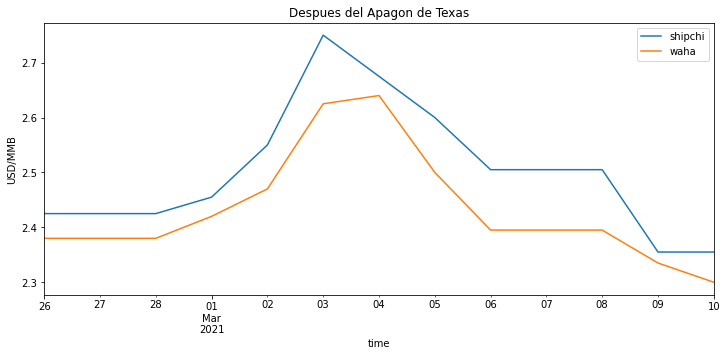

In [7]:
df[(df['date'] > '2021-2-25')].plot(x = 'date',figsize=(12, 5))
plt.title("Despues del Apagon de Texas")
plt.xlabel("time")
plt.ylabel("USD/MMB")
plt.show()

Una vez comprendidas las series de tiempo procederemos a crear los modelos de predicción. 
Por limitaciones de tiempo, usaremos la serie de tiempo antesd del apagon de texas, para poder comparar claramente los dos modelos.

--------------------------------------------------------------------------------------------------------------------------

## Arima Forecast

In [8]:
#Haremos mas pequeño el df por cuestiones de tiempo
df = df[(df['date'] > '2015-01-01') &  (df['date'] < '2021-02-10')]
df.drop(['waha'], axis=1,inplace = True)
df.fillna(df.mean(), inplace = True)
df.isna().sum()

date       0
shipchi    0
dtype: int64

In [9]:
#Setting start and end dates and fetching the historical data
start = dt.datetime(2015,1,1)
end = dt.datetime(2021,2,10)
stk_data = gh(symbol='SBIN',start=start,end=end)

In [10]:
#Train / Test Split
train = df.iloc[:len(df)-14] 
test = df.iloc[len(df)-14:]

train['date'] = pd.to_datetime(train['date'], format='%d/%m/%Y')
test['date'] = pd.to_datetime(test['date'], format='%d/%m/%Y')

In [11]:
#Setting start and end dates and fetching the historical data
start = dt.datetime(2015,1,1)
end = dt.datetime(2021,2,10)
stk_data = gh(symbol='SBIN',start=start,end=end)

In [12]:
#Train / Test Split
train = df.iloc[:len(df)-14] 
test = df.iloc[len(df)-14:]

train['date'] = pd.to_datetime(train['date'], format='%d/%m/%Y')
test['date'] = pd.to_datetime(test['date'], format='%d/%m/%Y')

In [13]:
# Fit auto_arima function to Stock Market Data
stepwise_fit = auto_arima(train['shipchi'], start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0,
                          seasonal = True, d = 1, D = 1, trace = True, error_action ='ignore',
                          suppress_warnings = True, stepwise = True)         

  
# To print the summary 
stepwise_fit.summary() 


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=7.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1046.865, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=270.940, Time=0.76 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1048.835, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-73.312, Time=1.67 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=14.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-74.974, Time=1.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=269.263, Time=0.46 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=10.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-73.780, Time=2.20 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=10.93 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-72.974, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2217
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                  40.487
Date:                            Sun, 18 Jul 2021   AIC                            -74.974
Time:                                    06:12:47   BIC                            -57.880
Sample:                                         0   HQIC                           -68.728
                                           - 2217                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7534      0.003   -217.688      0.000      -0.760      -0.747
ar.S.L24      -0.3801      0.004   -103.069      0.000      -0.387      -0.373
sigma2         0.0562      0.000    300.329      0.000       0.056       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):           4240628.72
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.84
Prob(H) (two-sided):                  0.19   Kurtosis:                       217.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

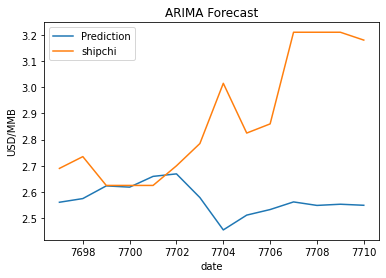

In [14]:
# Predictions for one-year against the test set 
prediction=pd.DataFrame(stepwise_fit.predict(n_periods = 14),index = test.index)
prediction.columns = ['Prediction']

# plot predictions and actual values 
prediction.plot(legend = True) 
test['shipchi'].plot(legend = True)
plt.title("ARIMA Forecast")
plt.xlabel("date")
plt.ylabel("USD/MMB")
plt.show()

In [15]:
# RMSE for ARIMA model
err_ARIMA = mean_squared_error(test['shipchi'], prediction, squared=False)

print('RMSE with ARIMA', err_ARIMA)

RMSE with ARIMA 0.4046450460105915


--------------------------------------------------------------------------------------------------------------------------

## LSTM Forecast

In [16]:
# Importamos nuestros datos de nuevo y los preparamos
df = pd.read_csv('data/cfe/data_historicos.csv')
df.rename(columns={'Fecha': 'date', 'Houston ShipChl (USD/MMB)': 'shipchi', 'Waha (USD/MMB)':'waha'}, inplace = True)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df_temp = pd.read_csv('data/cfe/df_temp_US.csv')
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y-%m-%d')
df_temp.drop(['Country'], axis=1,inplace = True)
df_temp = df_temp[(df_temp['date'] >= '2000-01-01')]
df = df[(df['date'] <= '2020-05-13')]
df_temp.reset_index(inplace = True)
df_temp.drop(['index'], axis=1,inplace = True)
df = df.merge(df_temp, how='left', on='date')
df2 = df[(df['date'] >= '2010-01-01')]

In [17]:
df.fillna(df.mean(), inplace = True)
df.isna().sum()

date       0
shipchi    0
waha       0
AvgTemp    0
dtype: int64

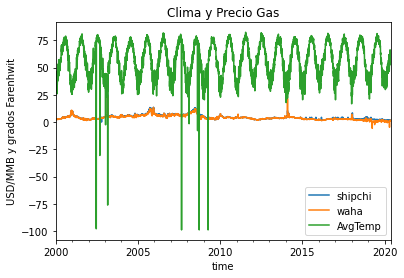

In [18]:
df.plot(x = 'date')
plt.title("Clima y Precio Gas")
plt.xlabel("time")
plt.ylabel("USD/MMB y grados Farenhwit")
plt.show()

In [29]:
#############LSTM########################
train_set = df.iloc[0:7425, 1:2].values
test_set = df.iloc[7425:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(14, 7425):
    X_train.append(training_set_scaled[i-14:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


#Defining the LSTM Recurrent Model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))


#Compiling and fitting the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)


# Getting the predicted price
dataset_train = df.iloc[:7425, 1:2]
dataset_test = df.iloc[7425:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 14:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(14, 28):
    X_test.append(inputs[i-14:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



Epoch 1/15
232/232 [==============================] - 10s 21ms/step - loss: 0.0050
Epoch 2/15
232/232 [==============================] - 5s 22ms/step - loss: 8.0748e-04
Epoch 3/15
232/232 [==============================] - 5s 20ms/step - loss: 8.2108e-04
Epoch 4/15
232/232 [==============================] - 5s 21ms/step - loss: 6.1642e-04
Epoch 5/15
232/232 [==============================] - 5s 21ms/step - loss: 5.2892e-04
Epoch 6/15
232/232 [==============================] - 5s 21ms/step - loss: 7.1031e-04
Epoch 7/15
232/232 [==============================] - 5s 21ms/step - loss: 5.3606e-04
Epoch 8/15
232/232 [==============================] - 5s 22ms/step - loss: 4.2221e-04
Epoch 9/15
232/232 [==============================] - 5s 21ms/step - loss: 5.7374e-04
Epoch 10/15
232/232 [==============================] - 5s 22ms/step - loss: 4.1489e-04
Epoch 11/15
232/232 [==============================] - 5s 22ms/step - loss: 5.8112e-04
Epoch 12/15
232/232 [==============================] - 

--------------------------------------------------------------------------------------------------------------------------

In [27]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

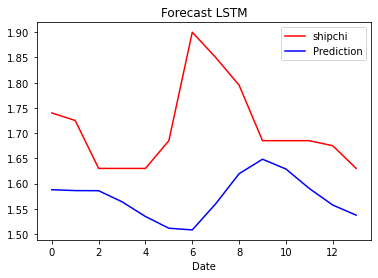

In [31]:

#Making predictions on the test data
predicted_price = regressor.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)

#Visualizing the prediction
plt.figure()
plt.plot(dataset_test.values, color = 'r', label = 'shipchi')
plt.plot(predicted_price, color = 'b', label = 'Prediction')
plt.title("Forecast LSTM")
plt.xlabel('Date')
plt.legend()
plt.show()

In [32]:
# RMSE for ARIMA model
err_LSTM = mean_squared_error(dataset_test.values,predicted_price, squared=False)

print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 0.16745331228828716
